## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [3]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

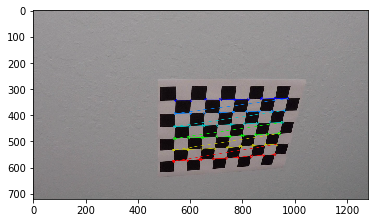

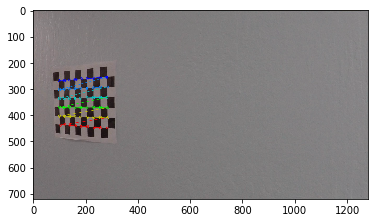

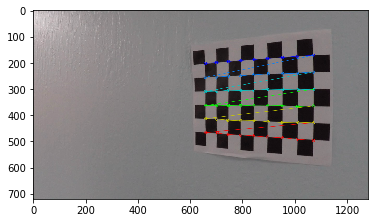

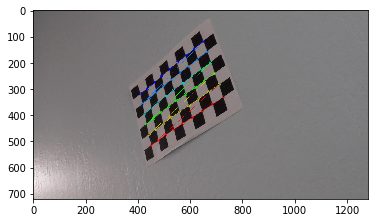

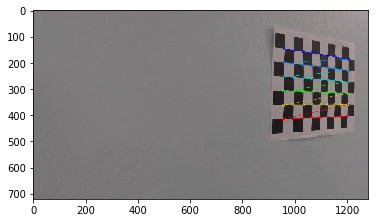

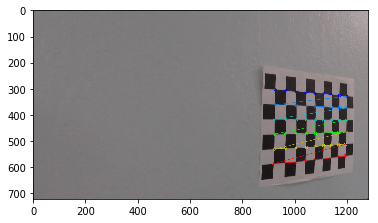

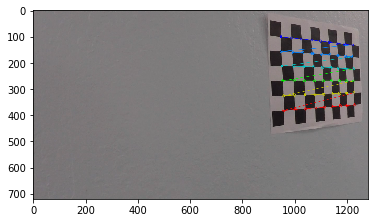

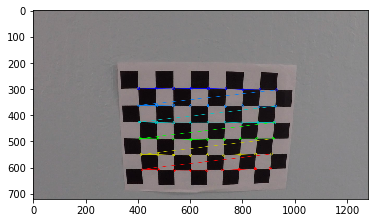

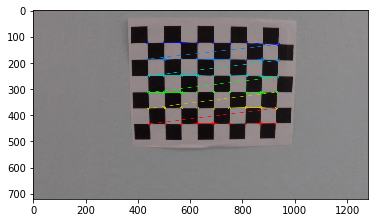

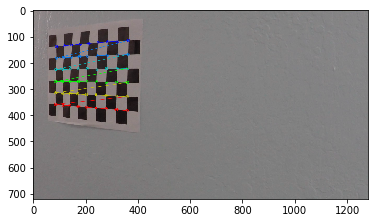

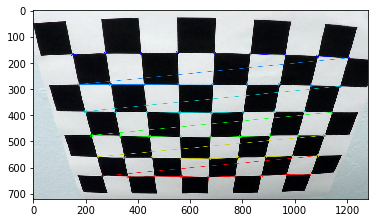

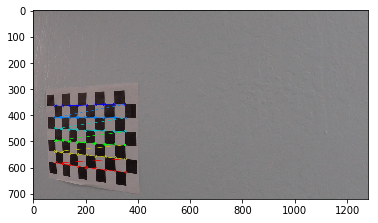

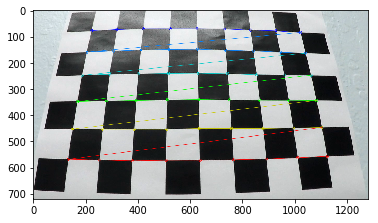

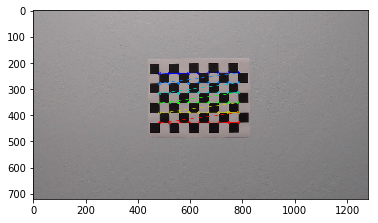

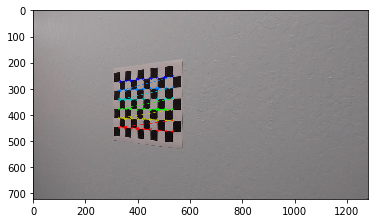

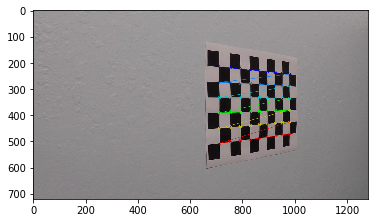

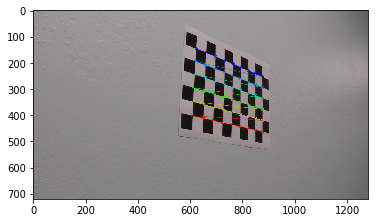

In [4]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## And so on and so forth...

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [6]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    # Find the chessboard corners
    ret, cn = cv2.findChessboardCorners(gray, (nx, ny), None)
    # 4) If corners found: 
    if ret == True:
            # a) draw corners
            cv2.drawChessboardCorners(img, (nx, ny), cn, ret)
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            src = np.float32([cn[0], cn[nx-1], cn[nx * (ny -1)], cn[(nx * ny) - 1]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            dst = np.float32([[100, 100],[1148,100],[100, 624],[1148, 624]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)
            img_size = (img.shape[1], img.shape[0])
            # e) use cv2.warpPerspective() to warp your image to a top-down view
            warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        plt.imshow(img)
        plt.show()
    #delete the next two lines
    #M = None
    #warped = np.copy(img) 
    return warped, M

In [7]:
img = cv2.imread('./camera_cal/calibration3.jpg')
warped_img, M = corners_unwarp(img, 9, 6, mtx, dist)

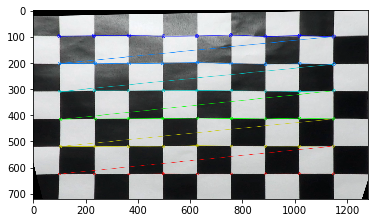

In [8]:
plt.imshow(warped_img)

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[ -2.41017956e-01  -5.30721172e-02  -1.15810355e-03  -1.28318856e-04
    2.67125291e-02]]


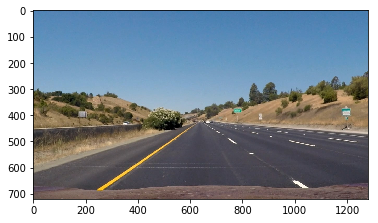

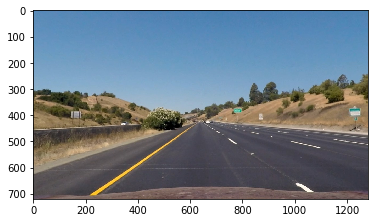

In [9]:

print(mtx, dist)
img = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.undistort(img, mtx, dist)
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()

(720, 1280)
(720, 1280)
lines 2
0
line [array([ 540.,  490.], dtype=float32), array([ 200.,  719.], dtype=float32)]
1
line [array([ 740.,  485.], dtype=float32), array([ 1110.,   719.], dtype=float32)]


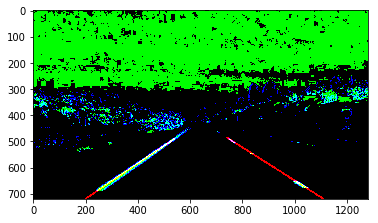

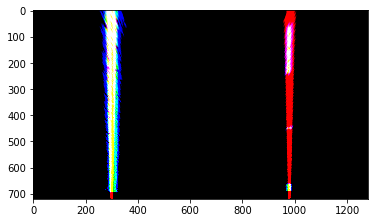

In [10]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    #print(vertices)
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def get_src_pts(img):
    h, w = img.shape
    vert=[]
    #upper_left
    vert.append([w/2 -100, h/2 +130])
    #lower_left
    vert.append([200, h-1])
    #upper_right
    vert.append([w/2 +100, h/2 +125])
    #lower_right
    vert.append([w-170, h-1])
    return np.floor(vert).astype(int)

def get_dst_pts(img):
    h, w = img.shape
    vert=[]
    #upper_left
    vert.append([300, 0])
    #lower_left
    vert.append([300, h-1])
    #upper_right
    vert.append([w-300, 0])
    #lower_right
    vert.append([w-1-300, h-1])
    
    return np.floor(vert).astype(int)

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    print('lines',len(lines))
    for i in range(len(lines)):
        print(i)
        [x1,y1], [x2,y2] = lines[i]
        print('line', lines[i])
        img = cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(100, 255), sx_thresh=(16, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    
    #bw_binary[(color_binary[:,:,2] == 1.) | (color_binary[:,:,1] == 5)] = 1
    lines_binary = np.zeros_like(s_binary)
    src = np.float32(get_src_pts(lines_binary))
    dst = np.float32(get_dst_pts(lines_binary))
    left_line = [src[0], src[1]]
    right_line = [src[2], src[3]]
    
    #print(src, dst)
    print(lines_binary.shape)
    print(s_binary.shape)
    
    # Convert scale to 0. - 1. from max of 255.
    lines_binary = draw_lines(lines_binary, [left_line,  right_line], thickness=5) / 255.
    
    color_binary = np.dstack((lines_binary, s_binary, sxbinary))
    plt.imshow(color_binary)
    plt.show()
    img_size = (color_binary.shape[1] ,  color_binary.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

warped = pipeline(img)
plt.imshow(warped)


1.0
(720, 1280, 3)


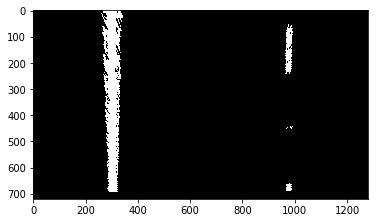

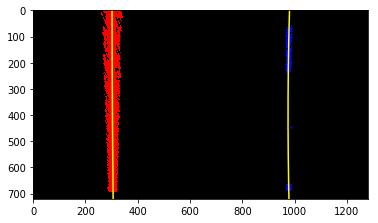

In [35]:
def find_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    print(np.max(out_img))
    print(out_img.shape)
    plt.imshow(out_img)
    plt.show()
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1., 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1.]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

def get_lanes_binary(img):
    img_binary = np.zeros_like(img[:,:,0])
    img_binary[(img[:,:,1] == 1.) | (img[:,:,2] == 1.)] = 1.
    return img_binary
    
bw = get_lanes_binary(warped)
#plt.imshow(bw)
#plt.show()

lanes = find_lanes(bw)

